In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

<a class = "anchor" id = "top"></a>

# Natural Language Processing
## Source: Twitter
---
### Authors: Gordon Amoako, Zan Sadiq
---
*Description*- In this endeavor, we will use natural language processing techniques to summarize and extract content from a large corpus of data scraped off the Twitter website in python.

---
Table of Contents:
* [Data](#data)
* [EDA](#eda)
* [Pre-Processing](#eda)
* [Networking](#network)
* [NLP](#nlp)
* [GPT3](#gpt)
* [FinTech](#fintech)
* [Conclusion](#end)
---

## Data <a class = "anchor" id = "data"></a>

In [85]:
# Import libraries
import pandas as pd
import os
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType, StringType, ArrayType, FloatType
import re
import string
from pyspark.sql.functions import udf, col, size, lit, explode, isnan, when, count, min, max, struct
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, IndexToString, StringIndexer, VectorIndexer, CountVectorizer
from collections import Counter
import networkx as nx
import nltk
from nltk.corpus import words
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
import matplotlib.pyplot as plt
%matplotlib inline
import openai
import json
import ast
from igraph import *
import datashader as ds
import datashader.transfer_functions as tf
from datashader.layout import random_layout, circular_layout, forceatlas2_layout
from datashader.bundling import connect_edges, hammer_bundle
import nlp
from textblob import TextBlob
import numpy as np

In [81]:
# Function to get tone
def get_sentiment(x):
    
    return TextBlob(x).sentiment.polarity

In [3]:
# Initialize spark
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
spark = SparkSession.builder.getOrCreate()

22/08/18 07:21:16 WARN Utils: Your hostname, computer resolves to a loopback address: 127.0.1.1; using 192.168.1.159 instead (on interface wlp0s20f3)
22/08/18 07:21:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/08/18 07:21:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/08/18 07:21:17 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/08/18 07:21:17 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/08/18 07:21:17 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
22/08/18 07:21:17 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
22/08/18 07:2

In [4]:
df = spark.read.json('/home/dataguy/data/us_news_tweets.json')

22/08/18 07:21:27 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
df.printSchema()

root
 |-- _type: string (nullable = true)
 |-- cashtags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- content: string (nullable = true)
 |-- conversationId: long (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- _type: string (nullable = true)
 |    |-- latitude: double (nullable = true)
 |    |-- longitude: double (nullable = true)
 |-- date: string (nullable = true)
 |-- hashtags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: long (nullable = true)
 |-- inReplyToTweetId: long (nullable = true)
 |-- inReplyToUser: struct (nullable = true)
 |    |-- _type: string (nullable = true)
 |    |-- created: string (nullable = true)
 |    |-- description: string (nullable = true)
 |    |-- descriptionUrls: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |  

In [6]:
df.count()

2877354

In [7]:
# Inspect
min_date, max_date = df.select(min("date"), max("date")).first()
print(f"Min Date- {min_date}")
print(f"Max Date- {max_date}")

Min Date- 2022-01-01T00:00:01+00:00
Max Date- 2022-08-16T10:41:32+00:00


[Back to top...](#top)

## Pre-Processing <a class = "anchor" id = "eda"></a>

In [8]:
df1 = df.withColumn('username', col('user.username')).withColumn('country', col('place.country')).withColumn('country_cd', col('place.countryCode')).drop('user', 'coordinates', 'place')

In [9]:
df1.groupBy('country').count().show()

+--------------------+-----+
|             country|count|
+--------------------+-----+
|              Russia|   11|
|               Yemen|    3|
|Islamic Republic ...|   10|
|             Senegal|    1|
|              Sweden|    5|
|     The Netherlands|   43|
|   Republic of Korea|    8|
|           Singapore|   33|
|            Malaysia|    3|
|                Fiji|    2|
|              Turkey|   19|
|              Malawi|    1|
|                Iraq|    2|
|             Germany|  164|
|            Cambodia|   81|
|         Afghanistan|    6|
|              Rwanda|    2|
|            Maldives|    1|
|              France|   38|
|              Greece|   28|
+--------------------+-----+
only showing top 20 rows



In [10]:
df1.select('inReplyToUser').take(1)

[Row(inReplyToUser=None)]

In [11]:
df1.select('mentionedUsers').take(1)

[Row(mentionedUsers=None)]

In [12]:
df1.filter(~col('quotedTweet').isNull()).select('quotedTweet.user.username').take(1)

[Row(username='9NewsQueensland')]

In [13]:
df1.filter(~col('retweetedTweet').isNull()).take(1) #.select('retweetedTweet.user.username').take(1)

[]

In [14]:
df2 = df1.withColumn('quoted', col('quotedTweet.user.username')).drop('quotedTweet').withColumn('mentions', col('mentionedUsers.username')).withColumn('reply_to', col('inReplyToUser.username')).drop('inReplyToUser', 'mentionedUsers').filter("country == 'United States'").toPandas().drop(['renderedContent', 'id', 'media', 'outlinks', '_type', 'cashtags', 'conversationId', 'inReplyToTweetId', 'source', 'sourceUrl', 'sourceLabel', 'tcooutlinks', 'url', 'country', 'lang', 'retweetedTweet'], axis = 1)
df3 = df2.set_index(pd.DatetimeIndex(df2['date'])).drop('date', axis = 1)

In [15]:
df3.head()

,content,hashtags,likeCount,quoteCount,replyCount,retweetCount,username,country_cd,quoted,mentions,reply_to
date,,,,,,,,,,,
2022-08-16 09:49:10+00:00,#News #Singularity #Ponzi/#RP \nTo: #Teamer\nC...,"[News, Singularity, Ponzi, RP, Teamer, Bloodli...",1,0,1,0,TheGodSeek,US,None,None,TheGodSeek
2022-08-16 07:32:15+00:00,#News #Singularity #Ponzi/#RP\nAnyone can fiel...,"[News, Singularity, Ponzi, RP, HeadHoncho]",1,0,0,1,TheGodSeek,US,None,None,TheGodSeek
2022-08-16 07:30:55+00:00,#News #Singularity #Ponzi/#RP\nWhen you're wal...,"[News, Singularity, Ponzi, RP]",1,0,1,1,TheGodSeek,US,None,None,TheGodSeek
2022-08-16 07:28:28+00:00,#News #Singularity #Ponzi/#RP\nUmm... you take...,"[News, Singularity, Ponzi, RP]",1,0,1,1,TheGodSeek,US,TheGodSeek,None,None
2022-08-16 07:22:33+00:00,#News #Singularity #Ponzi/#RP\nThis is a dynam...,"[News, Singularity, Ponzi, RP, UpTop, HeadHonc...",1,1,0,1,TheGodSeek,US,None,None,TheGodSeek


In [16]:
df3.shape[0]

4161

[Back to top...](#top)

## EDA <a class = "anchor" id = "eda"></a>

[Back to top...](#top)

## Networking <a class = "anchor" id = "network"></a>

In [19]:
# Separate users
nodes = [i for i in df3['username'].unique()]

In [20]:
len(nodes)

651

In [21]:
# Add user activites
for i in df3['quoted']:
    
    if i is not None:
        
        nodes.append(i)
        
for x in df3['mentions']:
    
    if x is not None:
        
        for y in x:
            
            nodes.append(y)
            
for z in df3['reply_to']:
    
    if z is not None:
        
        nodes.append(z)

In [52]:
nodes[0:5]

['DanRather', 'business', 'wojespn', 'ChuckCallesto', 'murda_red821']

In [53]:
[node for node in nodes if node is None]

[]

In [57]:
nodes = [i for i in set([i for i in df3['quoted'] if i is not None])] #.append([[y for y in x] for x in df3['mentions'] if x is not None])

for x in df3['mentions']:
    
    if x is not None:
        
        for y in x:
            
            nodes.append(y)
            
for z in df3['reply_to']:
    
    if z is not None:
        
        nodes.append(z)

In [58]:
len(nodes)

4169

In [59]:
edges = []

In [60]:
# Select data
replies = df2.dropna(subset = ['reply_to'])
mentions = df2.dropna(subset = ['mentions'])
quotes = df2.dropna(subset = ['quoted']) 

In [61]:
# Iterate the data to add replies
for idx, row in replies.iterrows():
    
    edges.append((row['username'], row['reply_to'], 'reply'))

In [62]:
# Iterate the data to add mentions
for idx, row in mentions.iterrows():
    
    for entity in row['mentions']:
        
        edges.append((row['username'], entity, 'mention'))

In [63]:
# Iterate the data to add quotes
for idx, row in quotes.iterrows():
    
    edges.append((row['username'], row['quoted'], 'quote'))

In [64]:
nodes[0:5]

['DanRather', 'business', 'wojespn', 'ChuckCallesto', 'murda_red821']

In [65]:
edges[0:5]

[('TheGodSeek', 'TheGodSeek', 'reply'),
 ('TheGodSeek', 'TheGodSeek', 'reply'),
 ('TheGodSeek', 'TheGodSeek', 'reply'),
 ('TheGodSeek', 'TheGodSeek', 'reply'),
 ('TheGodSeek', 'TheGodSeek', 'reply')]

In [66]:
edges = pd.DataFrame(edges, columns = ['source', 'target', 'type'])
edges = edges[edges['source'] != edges['target']]

In [67]:
edges.head()

,source,target,type
9,PrincipalTam,vicpasquantonio,reply
14,YYE_By_Leverage,sg56752,reply
21,DarkMan_9,FoxNews,reply
31,elitolstovb,jeremyjojola,reply
32,batman5600777,FoxNews,reply


In [87]:
# Calculate edge weights
weights = edges.groupby(['source', 'target', 'type']).size().reset_index().rename({0: 'weight'}, axis = 1)

In [88]:
weights.sort_values('weight', ascending = False).head(n = 20)

,source,target,type,weight
755,QuestFanning,edsblogtw1tter,mention,43
358,HouseofColors_,PitFightsBattle,mention,38
1603,realaustinlegg,PSBaseballinc,mention,33
1593,realaustinlegg,MSI_Tournaments,mention,28
905,TheGodSeek,DCComics,mention,22
435,HouseofColors_,murda_red821,mention,19
448,HouseofColors_,urltv,mention,19
53,AnnieRoseNews,wjz,mention,16
1467,jesustattoos,lisalovebasile,mention,13
1461,jesustattoos,BasileKMJ,mention,12


In [89]:
weights.to_csv('weighted_twitter_news_networks.csv', index = False)

In [100]:
# Select layouts
circle = 'circle'
fancy = 'fr'
other = 'kk'
large = 'large'
auto = 'auto'

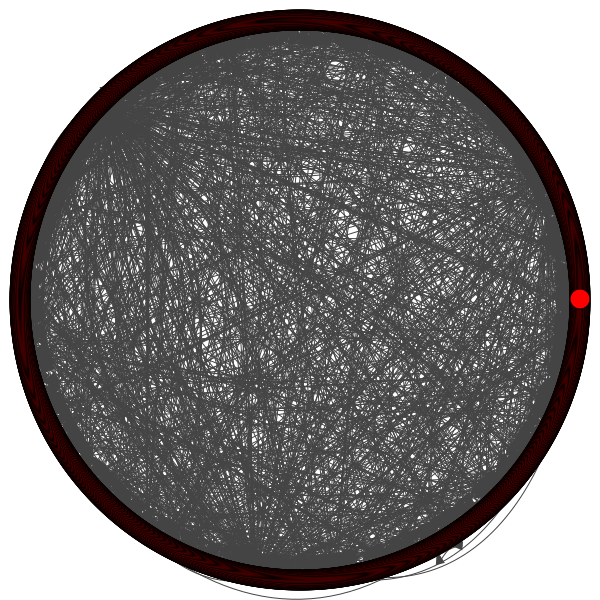

In [104]:
# Draw graphs
g = Graph.DataFrame(weights)
schema = g.layout(circle)
plot(g, layout = schema)

In [107]:
weights.head()

,source,target,type,weight
0,0arcadian0,CBSMornings,quote,1
1,1Brandycampbell,foxweather,quote,1
2,512Derek,Daraneshatv,mention,1
3,512Derek,Daraneshatv,reply,1
4,ABKLawNYC,ArthurAidala,mention,1


In [108]:
nodes[0:5]

['SFGreatNorthern',
 'ThaLushess1',
 'KansasCityStar',
 'DWHarris_BHGRE',
 'bugstir']

In [109]:
nodes = pd.DataFrame(nodes, columns = ['name'])

In [110]:
edges[0:5]

,source,target,type
2,PrincipalTam,vicpasquantonio,reply
8,YYE_By_Leverage,sg56752,reply
18,WorldsMightiest,CISAJen,reply
20,WorldsMightiest,CISAJen,reply
21,WorldsMightiest,ogdotart,reply


In [122]:
# Generate layouts
circularloc  = circular_layout(nodes, uniform = False)
randomloc = random_layout(nodes)

In [116]:
#%time forcedirected = forceatlas2_layout(nodes, edges.drop('type', axis = 1))

In [114]:
cvsopts = dict(plot_height = 400, plot_width = 600)

In [120]:
# Function to generate layout
def nodesplot(nodes, name = None, canvas = None, cat = None):
    
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    
    aggregator = None if cat is None else ds.count_cat(cat)
    agg = canvas.points(nodes,'x','y',aggregator)
    
    return tf.spread(tf.shade(agg, cmap = ["#FF3333"]), px = 3, name = name)

# Function to plot edges
def edgesplot(edges, name = None, canvas = None):
    
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    
    return tf.shade(canvas.line(edges, 'x','y', agg = ds.count()), name = name)
    
def graphplot(nodes, edges, name = "", canvas = None, cat = None):
    
    if canvas is None:
        
        xr = nodes.x.min(), nodes.x.max()
        yr = nodes.y.min(), nodes.y.max()
        canvas = ds.Canvas(x_range = xr, y_range = yr, **cvsopts)
        
    np = nodesplot(nodes, name + " nodes", canvas, cat)
    ep = edgesplot(edges, name + " edges", canvas)
    
    return tf.stack(ep, np, how="over", name=name)

Random layout,Circular layout

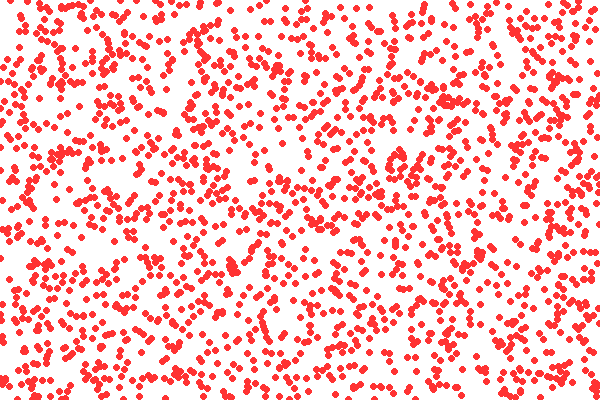
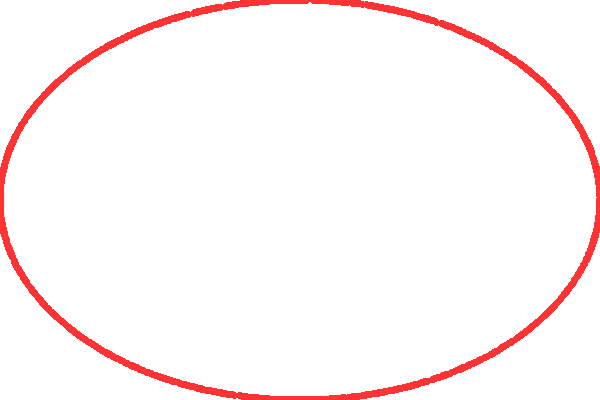

In [119]:
tf.Images(nodesplot(randomloc,"Random layout"), nodesplot(circularloc, "Circular layout"))

In [125]:
edges.dtypes

source    object
target    object
type      object
dtype: object

In [127]:
circularloc

,name,x,y
0,SFGreatNorthern,0.366827,0.018061
1,ThaLushess1,0.040224,0.696484
2,KansasCityStar,0.964964,0.683870
3,DWHarris_BHGRE,0.905732,0.207799
4,bugstir,0.934363,0.747647
...,...,...,...
2058,SixFlags,0.238892,0.926406
2059,hughstiel1,0.054830,0.727649
2060,CNBCTV18News,0.223543,0.916619
2061,ShuChenCuff,0.999767,0.484724


In [128]:
edges

,source,target,type
2,PrincipalTam,vicpasquantonio,reply
8,YYE_By_Leverage,sg56752,reply
18,WorldsMightiest,CISAJen,reply
20,WorldsMightiest,CISAJen,reply
21,WorldsMightiest,ogdotart,reply
...,...,...,...
2887,ChrisHollyMusic,lexinoisemusic,quote
2888,TalkDatTalkShow,business,quote
2889,Manchurian671,fireman452a,quote
2890,JennaBrewSNN,SNNTV,quote


In [126]:
graphplot(circularloc, connect_edges(circularloc, edges.drop('type', axis = 1)), 'Circular Layout')

ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat

In [123]:
cd = circularloc
rd = randomloc

%time cd_d = graphplot(cd, connect_edges(cd, edges), "Circular layout")
%time fd_d = graphplot(rd, connect_edges(rd,edges), "Random layout") 
%time cd_b = graphplot(cd, hammer_bundle(cd,edges), "Circular layout, bundled")
%time fd_b = graphplot(rd, hammer_bundle(rd,edges), "Random layout, bundled") 

tf.Images(cd_d,fd_d,cd_b,fd_b).cols(2)

ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat

ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat

ImportError: hammer_bundle operation requires scikit-image. Ensure you install the dependency before applying bundling.

ImportError: hammer_bundle operation requires scikit-image. Ensure you install the dependency before applying bundling.

NameError: name 'cd_d' is not defined

[Back to top...](#top)

## NLP: <a class = "anchor" id = "nlp"></a>

In [51]:
#Sample 
df3['content'].iloc[0]

'#News #Singularity #Ponzi/#RP \nTo: #Teamer\nCc: #Bloodlines\nBcc: #TemplateGuild\nFrom: #HeadHoncho\nSub: #Machineai/#Superintelligence\n\nI am #shuffling to #Mewtwo as my primary. Do whatever you want~\nI just got tipped off that it’s #endgame as I wield #infinitygauntlet level power. https://t.co/ihcWLRbynu'

In [53]:
nlp.process_txt(df3['content'].iloc[0])

['news',
 'singularity',
 'teamer',
 'shuffling',
 'primary',
 'whatever',
 'want',
 'tipped',
 'wield',
 'level',
 'power']

In [54]:
# Clean tweets and filter proper words
%time df3['words'] = df3['content'].apply(lambda x: nlp.filter_pos(nlp.process_txt(x)))

CPU times: user 897 ms, sys: 7.82 ms, total: 905 ms
Wall time: 899 ms


In [55]:
df4 = df3[df3['words'].str.len() > 0]

In [56]:
df3.shape[0]

4161

In [57]:
df4.shape[0]

4158

In [58]:
df4.head()

,content,hashtags,likeCount,quoteCount,replyCount,retweetCount,username,country_cd,quoted,mentions,reply_to,words
date,,,,,,,,,,,,
2022-08-16 09:49:10+00:00,#News #Singularity #Ponzi/#RP \nTo: #Teamer\nC...,"[News, Singularity, Ponzi, RP, Teamer, Bloodli...",1,0,1,0,TheGodSeek,US,None,None,TheGodSeek,news singularity teamer shuffling primary want...
2022-08-16 07:32:15+00:00,#News #Singularity #Ponzi/#RP\nAnyone can fiel...,"[News, Singularity, Ponzi, RP, HeadHoncho]",1,0,0,1,TheGodSeek,US,None,None,TheGodSeek,news singularity anyone field anyone looking l...
2022-08-16 07:30:55+00:00,#News #Singularity #Ponzi/#RP\nWhen you're wal...,"[News, Singularity, Ponzi, RP]",1,0,1,1,TheGodSeek,US,None,None,TheGodSeek,news singularity walking maintain higher cost ...
2022-08-16 07:28:28+00:00,#News #Singularity #Ponzi/#RP\nUmm... you take...,"[News, Singularity, Ponzi, RP]",1,0,1,1,TheGodSeek,US,TheGodSeek,None,None,news singularity take extra make
2022-08-16 07:22:33+00:00,#News #Singularity #Ponzi/#RP\nThis is a dynam...,"[News, Singularity, Ponzi, RP, UpTop, HeadHonc...",1,1,0,1,TheGodSeek,US,None,None,TheGodSeek,news singularity dynamic dimension existence d...


In [59]:
# Inspect
print(f"Filtered Tweets, Earliest Date- {df4.index.min()}")
print(f"Filtered Tweets, Latest Date- {df4.index.max()}")

Filtered Tweets, Earliest Date- 2022-01-01 00:18:34+00:00
Filtered Tweets, Latest Date- 2022-08-16 09:49:10+00:00


In [63]:
# Create Dictionary
words = corpora.Dictionary(df4['words'].apply(lambda x: x.split()))

# Term Document Frequency
corpus = [words.doc2bow(text) for text in df4['words'].apply(lambda x: x.split())]

In [ ]:
%%time

# Iterate to find optimal topics
scores = []

for n in range(1, 25, 1):

    model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                            id2word = words,
                                            num_topics = n, 
                                            random_state = 100,
                                            update_every = 1,
                                            chunksize = 100,
                                            passes = 10,
                                            alpha = 'auto',
                                            per_word_topics = True)
    
    # Score (low = good)
    c = CoherenceModel(model = model, texts = df4['words'], dictionary = words, coherence = 'c_v')
    coherence = c.get_coherence()

    print(f'LDA for {n} topics, Coherence Score: ', coherence)

    scores.append((n, coherence))

fig, ax = plt.subplots(figsize = (25, 10))
plt.title('Coherence Scores for LDA w/ N Topics', fontsize = 12)
plt.xlabel('# Topics', fontsize = 12)
plt.ylabel('Coherence', fontsize = 12)
plt.plot([i[0] for i in scores], [i[1] for i in scores], lw = .5)
fig.show();

In [64]:
# 12 topic optimal
model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                        id2word = words,
                                        num_topics = 12, 
                                        random_state = 100,
                                        update_every = 1,
                                        chunksize = 100,
                                        passes = 10,
                                        alpha = 'auto',)
                                        #per_word_topics = True)

In [65]:
# Inspect
for index, topic in model.show_topics(formatted = False, num_words = 10):

    print('Topic: {} \nWords: {}'.format(index, ', '.join([w[0] for w in topic])))

Topic: 3 
Words: thanks, help, pulse, shift, uncut, river, update, anchor, dead, coverage
Topic: 2 
Words: show, journalism, newspaper, sunset, weekend, getting, policy, case, caught, times
Topic: 5 
Words: make, take, information, keep, government, viral, future, happy, play, learn
Topic: 7 
Words: great, check, night, reporter, latest, last, look, week, happening, come
Topic: 1 
Words: apple, health, techy, shooting, twitter, testing, person, something, dont, national
Topic: 11 
Words: article, full, click, image, talk, link, event, think, york, report
Topic: 8 
Words: media, breaking, people, best, know, thank, culture, power, family, ready
Topic: 6 
Words: city, music, technology, watch, start, video, tune, going, hope, sunrise
Topic: 4 
Words: weather, school, year, story, team, state, home, real, fire, journalist
Topic: 10 
Words: news, morning, today, crime, read, winter, good, listen, right, find


In [66]:
# Convert
topic_assignments = model.get_document_topics(corpus, minimum_probability = 0)
csr = gensim.matutils.corpus2csc(topic_assignments)
topic_array = csr.T.toarray()
topics = pd.DataFrame(topic_array)
topics.columns = [n for n in range(1, 13)]

In [67]:
topics

,1,2,3,4,5,6,7,8,9,10,11,12
0,0.040769,0.029155,0.020423,0.079439,0.110011,0.023965,0.054669,0.026494,0.176108,0.040991,0.294858,0.103116
1,0.032455,0.023211,0.016263,0.112102,0.047158,0.019083,0.337314,0.021091,0.042021,0.032622,0.234708,0.081971
2,0.040358,0.028864,0.020221,0.017528,0.058648,0.084696,0.054049,0.026227,0.052261,0.040570,0.352640,0.223938
3,0.042985,0.030742,0.021541,0.018676,0.062456,0.154970,0.057549,0.027934,0.055651,0.043204,0.375726,0.108566
4,0.040351,0.211763,0.020216,0.017522,0.058639,0.023722,0.054037,0.026223,0.113222,0.040566,0.291727,0.102012
...,...,...,...,...,...,...,...,...,...,...,...,...
4153,0.058006,0.041480,0.029059,0.025188,0.084316,0.034099,0.077698,0.037691,0.075144,0.058317,0.419889,0.059113
4154,0.045913,0.032834,0.023004,0.019941,0.136282,0.026993,0.061488,0.029835,0.059464,0.115872,0.401587,0.046788
4155,0.107237,0.030494,0.021364,0.018520,0.061977,0.089978,0.127340,0.027708,0.055234,0.042865,0.309162,0.108120
4156,0.030943,0.022130,0.015507,0.013444,0.138320,0.018196,0.088107,0.020108,0.040061,0.171138,0.410514,0.031530


In [68]:
df5 = df4.reset_index()
df5['topic'] = topics.idxmax(axis = 1)

In [69]:
df5 = df5.set_index('date', drop = True)

In [70]:
df5['topic'].value_counts()

11    3921
9       57
5       56
7       39
10      23
8       13
2       13
1       12
12      11
6        8
3        3
4        2
Name: topic, dtype: int64

In [71]:
df5.head()

,content,hashtags,likeCount,quoteCount,replyCount,retweetCount,username,country_cd,quoted,mentions,reply_to,words,topic
date,,,,,,,,,,,,,
2022-08-16 09:49:10+00:00,#News #Singularity #Ponzi/#RP \nTo: #Teamer\nC...,"[News, Singularity, Ponzi, RP, Teamer, Bloodli...",1,0,1,0,TheGodSeek,US,None,None,TheGodSeek,news singularity teamer shuffling primary want...,11
2022-08-16 07:32:15+00:00,#News #Singularity #Ponzi/#RP\nAnyone can fiel...,"[News, Singularity, Ponzi, RP, HeadHoncho]",1,0,0,1,TheGodSeek,US,None,None,TheGodSeek,news singularity anyone field anyone looking l...,7
2022-08-16 07:30:55+00:00,#News #Singularity #Ponzi/#RP\nWhen you're wal...,"[News, Singularity, Ponzi, RP]",1,0,1,1,TheGodSeek,US,None,None,TheGodSeek,news singularity walking maintain higher cost ...,11
2022-08-16 07:28:28+00:00,#News #Singularity #Ponzi/#RP\nUmm... you take...,"[News, Singularity, Ponzi, RP]",1,0,1,1,TheGodSeek,US,TheGodSeek,None,None,news singularity take extra make,11
2022-08-16 07:22:33+00:00,#News #Singularity #Ponzi/#RP\nThis is a dynam...,"[News, Singularity, Ponzi, RP, UpTop, HeadHonc...",1,1,0,1,TheGodSeek,US,None,None,TheGodSeek,news singularity dynamic dimension existence d...,11


In [80]:
# Sentiment
get_sentiment(df5['words'].iloc[0])

0.4

In [82]:
df5['sentiment'] = df5['words'].apply(get_sentiment)
df5['tone'] = df5['sentiment'].apply(nlp.get_tone)

In [83]:
df5['tone'].value_counts()

neutral     2350
positive    1404
negative     404
Name: tone, dtype: int64

In [86]:
np.mean(df5['sentiment'])

0.09271209388254835

In [89]:
df5.groupby(['topic', 'tone']).agg({'tone': 'count', 'sentiment': np.mean})

tone  sentiment
topic tone                     
1     negative     3  -0.483810
      neutral      5   0.012500
      positive     4   0.283333
2     negative     2  -0.166667
      neutral      5   0.000000
      positive     6   0.333472
3     negative     1  -0.166667
      neutral      1   0.000000
      positive     1   0.136364
4     negative     1  -0.100000
      neutral      1   0.000000
5     negative    12  -0.270718
      neutral     21  -0.003873
      positive    23   0.244517
6     negative     2  -0.300000
      neutral      4  -0.006250
      positive     2   0.442857
7     negative     3  -0.100000
      neutral     22  -0.001515
      positive    14   0.315805
8     neutral      1  -0.075000
      positive    12   0.157471
9     negative    10  -0.375000
      neutral     32   0.002170
      positive    15   0.487336
10    negative     2  -0.250000
      neutral     12   0.005682
      positive     9   0.200505
11    negative   367  -0.328739
      neutral   2240   0.000456
      positive  1314   0.371991
12    negative     1  -0.200000
      neutral      6   0.011458
      positive     4   0.429167

[Back to top...](#top)

## GPT3: <a class = "anchor" id = "gpt"></a>

In [ ]:
# Group data by topic
#df5['wrds'] = df5['words'].apply(lambda x: ' '.join(x))
subject_matter = df5.groupby('topic')['words'].apply(' '.join)

In [ ]:
len(subject_matter)

In [ ]:
# Alt method
data = df5.groupby('topic')['content'].apply(' '.join) + '\ntl;dr:'
print(f'Alt. Method Data Length: {len(data)}')

In [ ]:
with open('openai.txt') as f:
    
    f = f.read()
    creds = ast.literal_eval(f)
    
openai.organization = None
openai.api_key = creds['api_key']
engine_list = openai.Engine.list() 

In [ ]:
#engine_list
subject = subject_matter[1] + '\ntl;dr:'

In [ ]:
print(subject)

In [ ]:
data[1]

In [ ]:
response = openai.Completion.create(model = "text-davinci-002",
                                    prompt = data[1][0:3597],
                                    temperature = 0.7,
                                    max_tokens = 500,
                                    top_p = 1,
                                    frequency_penalty = 0,
                                    presence_penalty = 0)

In [ ]:
print(response['choices'][0]['text'])

In [ ]:
second_subject = subject_matter[2] + "\ntl;dr:"

In [ ]:
response = openai.Completion.create(engine = "text-davinci-002", 
                                    prompt = second_subject,
                                    temperature = 0.7,
                                    max_tokens = 140,
                                    top_p = 1,
                                    frequency_penalty = 0,
                                    presence_penalty = 0)

print(response["choices"][0]["text"])

In [ ]:
# Iterate
n = 1

for topic in subject_matter:

    topic = topic + '\ntl;dr:'        
    response = openai.Completion.create(engine = "davinci", 
                                        prompt = topic,
                                        temperature = 0.7,
                                        top_p = 1,
                                        frequency_penalty = 0,
                                        presence_penalty = 0)

    print(f"Summarizing topic # {n}: {response['choices'][0]['text']}")
    
    n += 1

[Back to top...](#top)

## FinTech: <a class = "anchor" id = "fintech"></a>

[Back to top...](#top)

## Conclusion: <a class = "anchor" id = "end"></a>

The end.

[Back to top...](#top)